# many_analyses_plots
Author: Noah Stiegler

April 2023

This notebook is for analyzing the results of many inference runs on many checkpoints on many data files

First, import everything we'll need

In [4]:
# Everything uses numpy
import numpy as np

# Import matplotlib for viewing confusion matrices
import matplotlib.pyplot as plt

# Import from sklearn for making a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

All of the datafiles I used are listed in full_data_files.txt. First check if the file is there

In [10]:
%%bash
ls /cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt

/cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt


Then get all of the filenames from the file

In [17]:
with open("/cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt") as f:
    files = [line.rstrip() for line in f]
    
print(files)

['mlrecodata_bnb_nu_0540.root', 'mlrecodata_bnb_nu_0550.root', 'mlrecodata_bnb_nu_0553.root', 'mlrecodata_bnb_nu_0560.root', 'mlrecodata_bnb_nu_0563.root', 'mlrecodata_bnb_nu_0570.root', 'mlrecodata_bnb_nu_0572.root', 'mlrecodata_bnbnue_0460.root', 'mlrecodata_bnbnue_0462.root', 'mlrecodata_bnbnue_0472.root', 'mlrecodata_bnbnue_0475.root', 'mlrecodata_bnbnue_0482.root', 'mlrecodata_bnbnue_0490.root', 'mlrecodata_bnbnue_0492.root']


In [23]:
# Extract Confusion Matrices & Labels from a .npy saved analysis file
# Returns cosmics, non_cosmics, labels
def extract_cms(filepath):
    # Open the saved file & load in data
    with open(filepath, 'rb') as f:
        result = np.load(f, allow_pickle=True)
    
    # Get cosmic, non-cosmic, and label data
    # cosmic and non-cosmic are still arrays of confusion matrices for each event, will want to combine
    non_cosmics = [event["confusion_matrices"]["non_cosmics"] for event in result]
    cosmics = [event["confusion_matrices"]["cosmics"] for event in result]
    labels = result[0]["confusion_matrices"]["labels"] # Labels should be the same for all, so just need labels from one
    
    # Combine confusion matrices from all events, and then from the non-cosmics and cosmics for all events
    all_non_cosmics = sum(non_cosmics)
    all_cosmics = sum(cosmics)
    
    # Return stuff
    return all_cosmics, all_non_cosmics, labels

In [62]:
# Setup
OUTPUT_DIR = "/cluster/home/nstieg01/validation_proj/slurm_results/"

# Loop over all 10 chosen snapshots, filling out this array as we see them
snapshots = [None, None, None, None, None, None, None, None, None, None]
snapshot_nums = range(129999, 760000, 70000)
for i, snapshot_num in enumerate(snapshot_nums):
    # Setup results for each snapshot
    result = {}
    all_cosmics = []
    all_non_cosmics = []
    all_labels = []
    
    # Loop over all files analyzed for each snapshot and extract cosmics & non-cosmics
    for file in files:
        analysis_location = OUTPUT_DIR + "analysis_data_" + str(snapshot_num) + "_" + str(file) + ".npy"
        cosmics, non_cosmics, labels = extract_cms(analysis_location)
        all_cosmics.append(cosmics)
        all_non_cosmics.append(non_cosmics)
        all_labels.append(labels)
    
    # Add together all individual confusion matrices from each file & put in result
    result["cosmics"] = sum(all_cosmics)
    result["non_cosmics"] = sum(all_non_cosmics)
    result["total"] = result["cosmics"] + result["non_cosmics"]
    result["labels"] = all_labels[0]
    
    # Store this snapshot's result
    snapshots[i] = result

In [49]:
print(snapshots[0]["labels"])

['proton', 'MIPs', 'e$^-$/e$^+$/$\\gamma$', '$\\Delta$-ray', 'Michel', 'ghost']


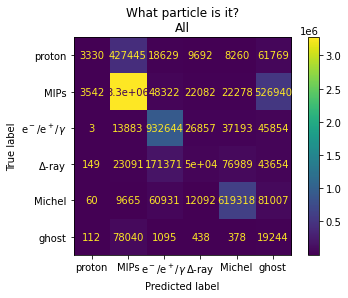

In [51]:
# Plot the total confusion matrix for all events
disp = ConfusionMatrixDisplay(confusion_matrix=snapshots[0]["non_cosmics"], display_labels=snapshots[0]["labels"])
disp.plot()
plt.title("What particle is it?\nAll")
plt.show()

In [75]:
# Get stats each snapshot
# proton_rec = []
# MIP_rec = []
# e_rec = []
# delta_rec = []
# michel_rec = []
# ghost_rec = []
total_acc = []
non_cosmic_acc = []
cosmic_acc = []
for snapshot in snapshots:
    # proton_rec.append()
    total_acc.append(sum(snapshot["total"].diagonal()) / np.sum(snapshot["total"]))
    non_cosmic_acc.append(sum(snapshot["non_cosmics"].diagonal()) / np.sum(snapshot["non_cosmics"]))
    cosmic_acc.append(sum(snapshot["cosmics"].diagonal()) / np.sum(snapshot["cosmics"]))

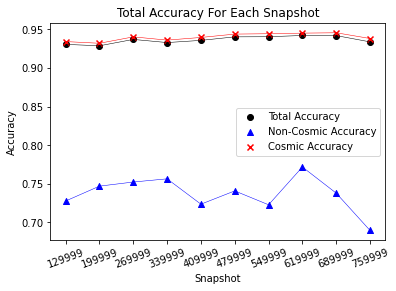

In [77]:
plt.plot(snapshot_nums, total_acc, color="black", linewidth=.5)
plt.scatter(snapshot_nums, total_acc, label="Total Accuracy", color='black')

plt.plot(snapshot_nums, non_cosmic_acc, color="blue", linewidth=.5)
plt.scatter(snapshot_nums, non_cosmic_acc, label="Non-Cosmic Accuracy", color='blue', marker="^")

plt.plot(snapshot_nums, cosmic_acc, color="red", linewidth=.5)
plt.scatter(snapshot_nums, cosmic_acc, label="Cosmic Accuracy", color='red', marker='x')

plt.title("Total Accuracy For Each Snapshot")
plt.ylabel("Accuracy")
plt.xlabel("Snapshot")
plt.xticks(snapshot_nums, rotation=20)
plt.legend()
plt.show();
